In [56]:
import torch
from torchtext import data
from torchtext import datasets
import random
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

In [21]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype = torch.float)

# download data from PyTorch

In [22]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [23]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [24]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of testing examples: 25000


In [25]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [39]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [40]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [41]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

# regular RNN

In [42]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [43]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,592,105 trainable parameters


In [45]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [46]:
criterion = nn.BCEWithLogitsLoss()

In [47]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [48]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [49]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [50]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [51]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 6m 12s
	Train Loss: 0.694 | Train Acc: 50.08%
	 Val. Loss: 0.692 |  Val. Acc: 51.80%
Epoch: 02 | Epoch Time: 6m 25s
	Train Loss: 0.694 | Train Acc: 50.57%
	 Val. Loss: 0.691 |  Val. Acc: 52.09%
Epoch: 03 | Epoch Time: 5m 59s
	Train Loss: 0.693 | Train Acc: 51.47%
	 Val. Loss: 0.692 |  Val. Acc: 51.89%
Epoch: 04 | Epoch Time: 6m 8s
	Train Loss: 0.693 | Train Acc: 51.56%
	 Val. Loss: 0.692 |  Val. Acc: 51.69%
Epoch: 05 | Epoch Time: 6m 27s
	Train Loss: 0.693 | Train Acc: 51.21%
	 Val. Loss: 0.691 |  Val. Acc: 52.25%


In [52]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.696 | Test Acc: 50.99%


# plot results

In [54]:
train_loss_rnn = [0.694, 0.694, 0.693, 0.693, 0.693]
train_acc_rnn = [50.08, 50.57, 51.47, 51.56, 51.21] 
val_loss_rnn = [0.692, 0.691, 0.692, 0.692, 0.691]
val_acc_rnn = [51.80, 52.09, 51.89, 51.69, 52.25]

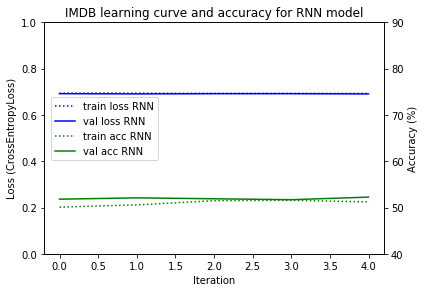

In [62]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss (CrossEntropyLoss)')
ax1.plot(train_loss_rnn, label="train loss RNN", color="blue", linestyle=':')
ax1.plot(val_loss_rnn, label="val loss RNN", color="blue")
ax1.set_ylim(0.0, 1.0)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)')  # we already handled the x-label with ax1
ax2.plot(train_acc_rnn, label="train acc RNN", color="green", linestyle=':')
ax2.plot(val_acc_rnn, label="val acc RNN", color="green")
ax2.set_ylim(40, 90)
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.legend(loc=(0.12, 0.45))

plt.title("IMDB learning curve and accuracy for RNN model")

plt.show()